# 🌍 ESG & 💲Financial Intelligence Platform
## AI-Powered Analysis of Corporate Reports (ESG And Annual)

**🎯 What this does:**
- Automatically processes PDF reports from Google Cloud Storage
- Uses Gemini 2.5 Pro to extract financial & ESG metrics
- Generates forecasts using Google's TimesFM 2.0 model
- Analyzes companies: Amgen, Novartis, Target

**📊 Features:**
- ✅ Automated PDF processing from Cloud Storage
- ✅ AI-powered data extraction (Financial + ESG metrics)
- ✅ Revenue forecasting with TimesFM 2.0
- ✅ Multi-company comparative analysis



# 🔑Setup & Authentication

In [1]:

print("🌟 Welcome to the ESG & Financial Intelligence Platform!")
print("🔧 Setting up environment...")

# Authenticate with Google Cloud
from google.colab import auth
auth.authenticate_user()

# Install required packages
!pip install -q bigframes google-cloud-bigquery plotly seaborn

# Import libraries
import bigframes.pandas as bpd
from google.cloud import bigquery
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt

print("✅ Authentication complete!")
print("✅ Libraries installed!")

🌟 Welcome to the ESG & Financial Intelligence Platform!
🔧 Setting up environment...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.3 MB/s eta 0:00:00
✅ Authentication complete!
✅ Libraries installed!


# 🚀 Intializing Parameters

In [2]:
# Replace the below with other company names from this list:
# novartis, amgen, target, bankofmontreal, lloyd, wellsfargo

company1 = "bankofmontreal"
company2 ="none"
company3 = "none"

DATA_FILES_PATH="gs://report_insights/bankofmontreal"

PROJECT_ID = "intellitrend-project-dev"   # update if needed
PROJECT_LOCATION="US" # Others are EU, ASIA
CLOUD_RES_CONN = "ghack_conn" #must be all small case


DATASET_ID = "db_reports_insights_annual_esg" #Name of dataset to be created in BQ
OBJ_TABLE_ID = "all_reports_obj_table_metadata" #Objec table name. That holds the metadata of the source files in GCS
RAW_TABLE_ID="all_reports_ai_text_raw"   # the output text that gets extracted based on prmpt - using ML.GENERATE_TEXT

CURATED_TABLE_ID="all_reports_ai_text_curated" # response_text extracted from JSON output
CURATED2_TABLE_ID="all_reports_ai_text_curated2" # the output text that gets extracted based on prmpt - using AI.GENERATE (An alternate way - for comparison)

FINAL_TABLE_ID="all_reports_ai_text_final" # output metrics info from the curated table - using AI.GENERATE_TABLE

METRICS_TABLE_ID = "all_reports_metrics"  # format the output final table
FORECAST_TABLE_ID="all_reports_forecast" # forecast table from the formatted-output

QUALIFIED_CLOUD_RES_CONN = f"{PROJECT_ID}.{PROJECT_LOCATION}.{CLOUD_RES_CONN}"

QUALIFIED_OBJ_TABLE_ID= f"{PROJECT_ID}.{DATASET_ID}.{OBJ_TABLE_ID}"
QUALIFIED_RAW_TABLE_ID= f"{PROJECT_ID}.{DATASET_ID}.{RAW_TABLE_ID}"

QUALIFIED_CURATED_TABLE_ID= f"{PROJECT_ID}.{DATASET_ID}.{CURATED_TABLE_ID}"
QUALIFIED_CURATED2_TABLE_ID= f"{PROJECT_ID}.{DATASET_ID}.{CURATED2_TABLE_ID}"

QUALIFIED_METRICS_TABLE_ID= f"{PROJECT_ID}.{DATASET_ID}.{METRICS_TABLE_ID}"

QUALIFIED_FINAL_TABLE_ID= f"{PROJECT_ID}.{DATASET_ID}.{FINAL_TABLE_ID}"
QUALIFIED_FORECAST_TABLE_ID= f"{PROJECT_ID}.{DATASET_ID}.{FORECAST_TABLE_ID}"

MODEL_ENDPOINT="gemini-2.5-pro"
MODEL_NAME="gemini_model_25pro"
QUALIFIED_MODEL_ID=f"{PROJECT_ID}.{DATASET_ID}.{MODEL_NAME}"




# --- Bigframes setup ---
bpd.options.bigquery.project = PROJECT_ID
bpd.options.bigquery.location = PROJECT_LOCATION

# 🏗️ Project Configuration

In [3]:

from google.colab import userdata

# Configure BigFrames
bpd.options.bigquery.project = PROJECT_ID
bpd.options.bigquery.location = PROJECT_LOCATION

# Initialize BigQuery client
client = bigquery.Client(project=PROJECT_ID)

print(f"✅ Project configured: {PROJECT_ID}")
print("✅ BigFrames ready for action!")

✅ Project configured: intellitrend-project-dev
✅ BigFrames ready for action!


# 🔗Create Cloud Resource Connection

In [27]:
!bq mk \
  --connection \
  --project_id={PROJECT_ID} \
  --connection_type=CLOUD_RESOURCE \
  --location={PROJECT_LOCATION} \
  {CLOUD_RES_CONN}

BigQuery error in mk operation: Already Exists: Connection
projects/573553606303/locations/us/connections/ghack_conn


# 🆔Fetch Service Account associated with the Cloud Res Connection

In [28]:
SERVICE_ACCT = !bq show --format=prettyjson \
  --connection \
  --project_id={PROJECT_ID} \
  --location={PROJECT_LOCATION} \
  {CLOUD_RES_CONN} | grep "serviceAccountId" | cut -d '"' -f 4

SERVICE_ACCT_EMAIL = SERVICE_ACCT[0]  # first (and only) line
print(SERVICE_ACCT_EMAIL)

bqcx-573553606303-2s0n@gcp-sa-bigquery-condel.iam.gserviceaccount.com


# 👥Give the below roles to the Conn Service Account:
  * objectViewer and  
  * aiplatformUser



In [29]:
import time

# Use $SERVICE_ACCT_EMAIL so the Python variable expands in the shell
!gcloud projects add-iam-policy-binding {PROJECT_ID} \
    --member="serviceAccount:$SERVICE_ACCT_EMAIL" \
    --role="roles/storage.objectViewer" \
    --format=none

!gcloud projects add-iam-policy-binding {PROJECT_ID} \
    --member="serviceAccount:$SERVICE_ACCT_EMAIL" \
    --role="roles/aiplatform.user" \
    --format=none

!gcloud projects add-iam-policy-binding {PROJECT_ID} \
    --member="serviceAccount:$SERVICE_ACCT_EMAIL" \
    --role="roles/bigquery.connectionUser" \
    --format=none


!gcloud projects add-iam-policy-binding {PROJECT_ID} \
    --member="serviceAccount:$SERVICE_ACCT_EMAIL" \
    --role="roles/run.invoker" \
    --format=none


# Wait ~60 seconds for IAM updates to propagate
# time.sleep(60)

Updated IAM policy for project [intellitrend-project-dev].
Updated IAM policy for project [intellitrend-project-dev].
Updated IAM policy for project [intellitrend-project-dev].
Updated IAM policy for project [intellitrend-project-dev].


#✦ Create the Gemini Model

In [30]:
# 🤖 Step 0a: Create Gemini 2.5 Pro Model
print("🤖 Creating Gemini 2.5 Pro model...")

create_model_sql = f"""
CREATE OR REPLACE MODEL `{QUALIFIED_MODEL_ID}`
REMOTE WITH CONNECTION `{QUALIFIED_CLOUD_RES_CONN}`
OPTIONS (ENDPOINT = '{MODEL_ENDPOINT}');
"""

try:
    job = client.query(create_model_sql)
    job.result()
    print("🎉 Gemini 2.5 Pro model created successfully!")
except Exception as e:
    print(f"⚠️  Model creation issue: {e}")

🤖 Creating Gemini 2.5 Pro model...
🎉 Gemini 2.5 Pro model created successfully!


# 𝄜 Create **Object Table** for PDF Reports

In [47]:
print(f"📁 Creating external table(Object Table): '{OBJ_TABLE_ID}' for PDF reports...")

create_external_table_sql = f"""
CREATE OR REPLACE EXTERNAL TABLE `{QUALIFIED_OBJ_TABLE_ID}`
WITH CONNECTION `{QUALIFIED_CLOUD_RES_CONN}`
OPTIONS (
  object_metadata = 'SIMPLE',
  uris = ['{DATA_FILES_PATH}/*']
);
"""

try:
    job = client.query(create_external_table_sql)
    job.result()
    print("✅ External table created successfully!")

    # Check what files we have
    check_files_sql = f"SELECT uri, size FROM `{QUALIFIED_OBJ_TABLE_ID}`  "
    files_df = bpd.read_gbq(check_files_sql)
    print(f"📄 Found {len(files_df)} files in storage")
    print("Sample files:")
    print(files_df.head())


except Exception as e:
    print(f"⚠️  Note: {e}")
    print("   Make sure your GCS bucket and connection are set up correctly")



📁 Creating external table(Object Table): 'all_reports_obj_table_metadata' for PDF reports...
✅ External table created successfully!
📄 Found 137 files in storage
Sample files:


                                                 uri      size
0  gs://report_insights/amgen/amgen_annualreport_...  12663856
1  gs://report_insights/amgen/amgen_annualreport_...   3651904
2  gs://report_insights/amgen/amgen_annualreport_...   3777808
3  gs://report_insights/amgen/amgen_annualreport_...  12725236
4  gs://report_insights/amgen/amgen_annualreport_...   8154936

[5 rows x 2 columns]


In [6]:

print(f"֎ Processing PDFs with {MODEL_NAME}...")
print(f"This analyzes {company1}, {company2}, and {company3} reports...")

generate_text_sql = f"""
CREATE OR REPLACE TABLE `{QUALIFIED_RAW_TABLE_ID}` AS
SELECT
  *
FROM
  ML.GENERATE_TEXT(
    MODEL `{QUALIFIED_MODEL_ID}`,
    (
      SELECT *
      FROM `{QUALIFIED_OBJ_TABLE_ID}`
      WHERE uri LIKE '%{company1}%'
         OR uri LIKE '%{company2}%'
         OR uri LIKE '%{company3}%'
    ),
    STRUCT(
      '''
        You are an expert ESG and Financial analyst. Use only the information provided in the document to answer.
        Fetch Financial and Sustainability Details including tabular and image data for each PDF.
        Ensure you fetch complete detailed information and metrics to answer any questions from the below sections:
        - Investor questions related to Financial Performance:
          - Balance Sheet & Liquidity
          - Business Strategy
          - Risk Factors
          - Governance & Leadership
          - Shareholder Value
        - Investor questions related to  ESG/Climate/Sustainability:
          - Environmental
          - Social
          - Governance (ESG-specific)
          - Risk & Opportunity
      ''' AS prompt,

      0 AS temperature,
      8092 AS max_output_tokens
    )
  );

"""
#print("\n\n the SQL \n\n", generate_text_sql)
try:
    print("⏳ Processing... This may take 2-3 minutes")
    job = client.query(generate_text_sql)
    job.result()

    # Check results
    check_sql = f"SELECT COUNT(*) as processed_files FROM `{QUALIFIED_RAW_TABLE_ID}`"
    result = client.query(check_sql).result()
    count = list(result)[0][0]
    print(f"✅ Successfully processed {count} files!")

except Exception as e:
    print(f"⚠️  Processing issue: {e}")

֎ Processing PDFs with gemini_model_25pro...
This analyzes bankofmontreal, wellsfargo, and jpmorganchase reports...
⏳ Processing... This may take 2-3 minutes
✅ Successfully processed 32 files!


#  ֎ Extract Financial & ESG Data - Using ML.GENERATE_TEXT

In [48]:

print(f"֎ Processing PDFs with {MODEL_NAME}...")
print(f"This analyzes {company1}, {company2}, and {company3} reports...")

generate_text_sql = f"""
CREATE OR REPLACE TABLE `{QUALIFIED_RAW_TABLE_ID}` AS (
SELECT
  *
FROM
  ML.GENERATE_TEXT(
    MODEL `{QUALIFIED_MODEL_ID}`,
    TABLE `{QUALIFIED_OBJ_TABLE_ID}`,
    STRUCT(
      '''
        You are an expert ESG and Financial analyst. Use only the information provided in the document to answer.
        Fetch Financial and Sustainability Details including tabular and image data for each PDF.
        Read the filename. If it is a sustainability report, please get only ESG details. If it is an annual report, get just the financials as below.
        Ensure you fetch details so it has answers for the below and only if company name is like {company1} or {company2} or {company3}:
        Financial Performance
        What is the total revenue this year?
        How has revenue changed compared to last year?
        What is the net profit or loss?
        How have the earnings per share (EPS) changed?
        Are gross margins improving or declining?
        Are operating margins stable or volatile?
        How has net margin shifted year over year?
        Is cash flow from operations positive and consistent?
        How much free cash flow is available?
        How are working capital levels trending?
        Balance Sheet & Liquidity
        What is the total debt level?
        Is the debt-to-equity ratio rising or falling?
        Does the company have enough liquidity to cover short-term liabilities?
        What is the current ratio and quick ratio?
        How much cash and equivalents are available?
        Are interest expenses sustainable?
        How sensitive is the company to interest rate changes?
        What is the level of contingent liabilities?
        Business Strategy
        What are the company’s core growth initiatives?
        Is management investing in new markets or products?
        How much is spent on research and development (R&D)?
        Are acquisitions or divestitures planned?
        Is the company expanding geographically?
        What is the company’s competitive advantage?
        Is the advantage sustainable against competitors?
        Is digital transformation a core part of the strategy?
        Risk Factors
        What macroeconomic risks affect the business?
        What industry-specific risks are highlighted?
        What operational risks are disclosed?
        Are supply chain risks material?
        Are legal or regulatory risks mentioned?
        How is foreign exchange risk managed?
        How dependent is revenue on a few customers?
        Are raw material price risks significant?
        Governance & Leadership
        Is the board majority independent?
        How many women or minorities are on the board?
        Is executive compensation performance-linked?
        Does management own significant equity?
        Are shareholder rights well protected?
        Is succession planning disclosed?
        Has management delivered on past promises?
        Is the auditor independent and credible?
        Shareholder Value
        Is the company paying dividends?
        Is the dividend payout sustainable?
        Is the dividend policy clear?
        Are share buybacks taking place?
        Is return on equity (ROE) improving?
        Is return on assets (ROA) stable?
        Has shareholder equity grown consistently?
        What is the earnings guidance for next year?
        Investor Questions – Sustainability Reports
        Environmental
        What is the total Scope 1 emissions?
        What is the total Scope 2 emissions?
        What is the total Scope 3 emissions?
        Are science-based targets disclosed?
        Has the company committed to net-zero?
        What percentage of energy is renewable?
        Is energy efficiency improving year over year?
        What is the total water withdrawal?
        What is water recycled or reused?
        Is the company exposed to water stress?
        How much total waste is generated?
        How much waste is recycled or diverted from landfill?
        Are hazardous waste levels disclosed?
        How sustainable are raw material sourcing practices?
        Are biodiversity risks addressed?
        Social
        What is the total workforce size?
        What percentage of employees are women?
        What percentage of leadership roles are held by women?
        What is minority representation in the workforce?
        What is the employee turnover rate?
        How many workplace injuries occurred?
        What is the lost-time injury frequency rate?
        Are labor rights respected across the supply chain?
        Is child labor risk disclosed in supply chains?
        Are employee training hours increasing per year?
        Are wages above local living wage levels?
        Is there employee engagement survey data?
        What community development initiatives exist?
        What philanthropic contributions were made?
        Is there disclosure on data privacy and cybersecurity?
        Governance (ESG-specific)
        Is there a dedicated board ESG committee?
        How often does the board review ESG matters?
        Is ESG risk included in enterprise risk management?
        Is executive compensation tied to ESG goals?
        Are ESG targets linked to management incentives?
        Is ESG performance externally assured?
        Are ESG disclosures aligned with GRI or SASB?
        Does the company report under TCFD or ISSB?
        Is CDP reporting publicly available?
        Are stakeholder engagement practices disclosed?
        Risk & Opportunity
        What are the identified physical climate risks?
        What are the identified transition risks?
        Is there disclosure on carbon pricing exposure?
        How dependent is revenue on carbon-intensive activities?
        What sustainability-linked opportunities are identified?
        Are green products or services generating revenue?
        Is access to sustainable finance increasing?
        Are suppliers evaluated for ESG performance?
        Are ESG clauses included in supplier contracts?
        Is there disclosure on product lifecycle impacts?
      ''' AS prompt,

      0 AS temperature,
      8092 AS max_output_tokens
    )
  )
WHERE uri like '%{company1}%' or uri like '%{company2}%' or  uri like '%{company3}%'
);
"""
#print("\n\n the SQL \n\n", generate_text_sql)
try:
    print("⏳ Processing... This may take 2-3 minutes")
    job = client.query(generate_text_sql)
    job.result()

    # Check results
    check_sql = f"SELECT COUNT(*) as processed_files FROM `{QUALIFIED_RAW_TABLE_ID}`"
    result = client.query(check_sql).result()
    count = list(result)[0][0]
    print(f"✅ Successfully processed {count} files!")

except Exception as e:
    print(f"⚠️  Processing issue: {e}")

֎ Processing PDFs with gemini_model_25pro...
This analyzes bankofmontreal, wellsfargo, and jpmorganchase reports...
⏳ Processing... This may take 2-3 minutes
✅ Successfully processed 32 files!


### *Alternate Method to ML.GENERATE_TEXT:*
# ֎Extract Financial & ESG Data - using AI.GENERATE

In [16]:

print(f"🧠 Processing PDFs with {MODEL_NAME}...")
print(f"This analyzes {company1}, {company2}, and {company3} reports...")

generate_text_sql2 = f"""
CREATE OR REPLACE TABLE `{QUALIFIED_CURATED2_TABLE_ID}` AS
SELECT
  uri,
  AI.GENERATE(
    CONCAT(
 "You are an expert ESG and Financial analyst. Use only the information provided in the document to answer.\n",
"Fetch Financial and Sustainability Details including tabular and image data for each PDF.\n",
"Ensure you fetch details so it has answers for the below: fetch as-it-is. Donot format",
"Read the filename. If its a sustainability report, please get only ESG details. And if its an annual report, get just the financials as below:",
"Financial Performance\n",
"What is the total revenue this year?\n",
"How has revenue changed compared to last year?\n",
"What is the net profit or loss?\n",
"How have the earnings per share (EPS) changed?\n",
"Are gross margins improving or declining?\n",
"Are operating margins stable or volatile?\n",
"How has net margin shifted year over year?\n",
"Is cash flow from operations positive and consistent?\n",
"How much free cash flow is available?\n",
"How are working capital levels trending?\n\n",

"Balance Sheet & Liquidity\n",
"What is the total debt level?\n",
"Is the debt-to-equity ratio rising or falling?\n",
"Does the company have enough liquidity to cover short-term liabilities?\n",
"What is the current ratio and quick ratio?\n",
"How much cash and equivalents are available?\n",
"Are interest expenses sustainable?\n",
"How sensitive is the company to interest rate changes?\n",
"What is the level of contingent liabilities?\n\n",

"Business Strategy\n",
"What are the company’s core growth initiatives?\n",
"Is management investing in new markets or products?\n",
"How much is spent on research and development (R&D)?\n",
"Are acquisitions or divestitures planned?\n",
"Is the company expanding geographically?\n",
"What is the company’s competitive advantage?\n",
"Is the advantage sustainable against competitors?\n",
"Is digital transformation a core part of the strategy?\n\n",

"Risk Factors\n",
"What macroeconomic risks affect the business?\n",
"What industry-specific risks are highlighted?\n",
"What operational risks are disclosed?\n",
"Are supply chain risks material?\n",
"Are legal or regulatory risks mentioned?\n",
"How is foreign exchange risk managed?\n",
"How dependent is revenue on a few customers?\n",
"Are raw material price risks significant?\n\n",

"Governance & Leadership\n",
"Is the board majority independent?\n",
"How many women or minorities are on the board?\n",
"Is executive compensation performance-linked?\n",
"Does management own significant equity?\n",
"Are shareholder rights well protected?\n",
"Is succession planning disclosed?\n",
"Has management delivered on past promises?\n",
"Is the auditor independent and credible?\n\n",

"Shareholder Value\n",
"Is the company paying dividends?\n",
"Is the dividend payout sustainable?\n",
"Is the dividend policy clear?\n",
"Are share buybacks taking place?\n",
"Is return on equity (ROE) improving?\n",
"Is return on assets (ROA) stable?\n",
"Has shareholder equity grown consistently?\n",
"What is the earnings guidance for next year?\n\n",

"Investor Questions – Sustainability Reports\n\n",

"Environmental\n",
"What is the total Scope 1 emissions?\n",
"What is the total Scope 2 emissions?\n",
"What is the total Scope 3 emissions?\n",
"Are science-based targets disclosed?\n",
"Has the company committed to net-zero?\n",
"What percentage of energy is renewable?\n",
"Is energy efficiency improving year over year?\n",
"What is the total water withdrawal?\n",
"What is water recycled or reused?\n",
"Is the company exposed to water stress?\n",
"How much total waste is generated?\n",
"How much waste is recycled or diverted from landfill?\n",
"Are hazardous waste levels disclosed?\n",
"How sustainable are raw material sourcing practices?\n",
"Are biodiversity risks addressed?\n\n",

"Social\n",
"What is the total workforce size?\n",
"What percentage of employees are women?\n",
"What percentage of leadership roles are held by women?\n",
"What is minority representation in the workforce?\n",
"What is the employee turnover rate?\n",
"How many workplace injuries occurred?\n",
"What is the lost-time injury frequency rate?\n",
"Are labor rights respected across the supply chain?\n",
"Is child labor risk disclosed in supply chains?\n",
"Are employee training hours increasing per year?\n",
"Are wages above local living wage levels?\n",
"Is there employee engagement survey data?\n",
"What community development initiatives exist?\n",
"What philanthropic contributions were made?\n",
"Is there disclosure on data privacy and cybersecurity?\n\n",

"Governance (ESG-specific)\n",
"Is there a dedicated board ESG committee?\n",
"How often does the board review ESG matters?\n",
"Is ESG risk included in enterprise risk management?\n",
"Is executive compensation tied to ESG goals?\n",
"Are ESG targets linked to management incentives?\n",
"Is ESG performance externally assured?\n",
"Are ESG disclosures aligned with GRI or SASB?\n",
"Does the company report under TCFD or ISSB?\n",
"Is CDP reporting publicly available?\n",
"Are stakeholder engagement practices disclosed?\n\n",

"Risk & Opportunity\n",
"What are the identified physical climate risks?\n",
"What are the identified transition risks?\n",
"Is there disclosure on carbon pricing exposure?\n",
"How dependent is revenue on carbon-intensive activities?\n",
"What sustainability-linked opportunities are identified?\n",
"Are green products or services generating revenue?\n",
"Is access to sustainable finance increasing?\n",
"Are suppliers evaluated for ESG performance?\n",
"Are ESG clauses included in supplier contracts?\n",
"Is there disclosure on product lifecycle impacts?\n"
      "Open and Read the PDF: "
    ),
    connection_id => '{QUALIFIED_CLOUD_RES_CONN}',
    endpoint => '{MODEL_ENDPOINT}',
    output_schema => 'uri STRING, response_text STRING'
  ).response_text AS response_text
FROM `{QUALIFIED_RAW_TABLE_ID}`
WHERE uri LIKE '%{company1}%' OR uri LIKE '%{company2}%' OR uri LIKE '%{company3}%';
"""

      # JSON_VALUE(
      #   OBJ.GET_ACCESS_URL(
      #     OBJ.MAKE_REF(uri, '{QUALIFIED_CLOUD_RES_CONN}'),
      #     'r'
      #   ),
      #   '$.access_urls.read_url'
      # )

# try:
#     print("⏳ Processing... This may take 2-3 minutes")
#     job = client.query(generate_text_sql2)
#     job.result()

#     # Check results
#     check_sql = f"SELECT COUNT(*) as processed_files FROM `{QUALIFIED_CURATED2_TABLE_ID}`"
#     result = client.query(check_sql).result()
#     count = list(result)[0][0]
#     print(f"✅ Successfully processed {count} files!")

# except Exception as e:
#     print(f"⚠️  Processing issue: {e}")


🧠 Processing PDFs with gemini_model_25pro...
This analyzes novartis, wellsfargo, and unitedhealth reports...
⏳ Processing... This may take 2-3 minutes
✅ Successfully processed 32 files!


# 🧹 Extract Clean Text Response

In [7]:

print("🧹 Cleaning and extracting response text...")

curate_results_sql = f"""
CREATE OR REPLACE TABLE `{QUALIFIED_CURATED_TABLE_ID}` AS
SELECT *,
  ARRAY_TO_STRING(
    ARRAY(
      SELECT JSON_VALUE(part, '$.text')
      FROM UNNEST(JSON_QUERY_ARRAY(
        JSON_QUERY(ml_generate_text_result, '$.candidates[0].content.parts')
      )) AS part
    ),
    ''
  ) AS response_text
FROM
  `{QUALIFIED_RAW_TABLE_ID}`;
"""

try:
    job = client.query(curate_results_sql)
    job.result()
    print("✅ Response text extracted and cleaned!")

    # Show sample of extracted text
    sample_sql = f"""
    SELECT uri, LEFT(response_text, 200) as sample_text
    FROM `{QUALIFIED_CURATED_TABLE_ID}`
    LIMIT 3
    """
    sample_df = bpd.read_gbq(sample_sql)
    print("\n📝 Sample extracted text:")
    for _, row in sample_df.iterrows():
        print(f"File: {row['uri']}")
        print(f"Text: {row['sample_text']}...\n")

except Exception as e:
    print(f"⚠️  Text extraction issue: {e}")

🧹 Cleaning and extracting response text...
✅ Response text extracted and cleaned!

📝 Sample extracted text:
File: gs://report_insights/bankofmontreal/bankofmontreal_sustainabilityreport_2020.pdf
Text: ...

File: gs://report_insights/wellsfargo/wellsfargo_annualreport_2022.pdf
Text: ...

File: gs://report_insights/wellsfargo/wellsfargo_annualreport_2023.pdf
Text: ...



# 📊 Extract Structured Metrics - Using AI.GENERATE_TABLE

In [8]:

print("📊 Generating structured financial and ESG metrics...")

generate_table_sql = f"""
CREATE OR REPLACE TABLE `{QUALIFIED_FINAL_TABLE_ID}` AS
SELECT *,
    DATE(CAST(fiscal_year AS STRING) || "-01-01") AS fiscal_year_date,
    CASE
        WHEN uri LIKE '%{company1}%' THEN '{company1}'
        WHEN uri LIKE '%{company2}%' THEN '{company2}'
        WHEN uri LIKE '%{company3}%' THEN '{company3}'
    END as company_name_formatted
FROM (
    SELECT *
    FROM AI.GENERATE_TABLE(
        MODEL `{QUALIFIED_MODEL_ID}`,
        (
            SELECT CONCAT(
                "You are an expert financial analyst and ESG/Climate analyst. Extract all financial metrics and sustainability metrics and KPIs from the provided text into structured data. ",
                "For Annual reports, focus on getting the financial metrics. And for Sustainability reports focus on getting ESG metrics. ",
                "Normalize numbers by removing commas, spaces, or symbols and convert all money values to dollars. ",
                "TEXT: ",
                response_text
            ) AS prompt,
            response_text as extracted_text,
            uri AS uri
        FROM `{QUALIFIED_CURATED_TABLE_ID}`
        ),
        STRUCT(
            'uris STRING, report_type STRING, company_name STRING, fiscal_year INT64, revenue_millions FLOAT64, net_income_millions FLOAT64, total_assets_millions FLOAT64, total_liabilities_millions FLOAT64, equity_millions FLOAT64, eps_basic FLOAT64, eps_diluted FLOAT64, dividends_per_share FLOAT64, employee_count INT64, business_segments ARRAY<STRING>, total_ghg_emissions FLOAT64, scope_1_ghg_emissions FLOAT64, scope_2_ghg_emissions FLOAT64, scope_3_ghg_emissions FLOAT64, carbon_intensity FLOAT64, energy_consumption FLOAT64, renewable_energy_usage FLOAT64, water_consumption FLOAT64, waste_generated FLOAT64, waste_recycled FLOAT64, sustainable_financing FLOAT64, reporting_period STRING, page_references ARRAY<STRING>, contexts ARRAY<STRING>, verbatim_quotes ARRAY<STRING>'
            AS output_schema,
            8192 AS max_output_tokens,
            0 AS temperature
        )
    ) t
);
"""

try:
    print("⏳ Structuring data... This may take 3-4 minutes")
    job = client.query(generate_table_sql)
    job.result()
    print("✅ Structured metrics extracted successfully!")

except Exception as e:
    print(f"⚠️  Table generation issue: {e}")

📊 Generating structured financial and ESG metrics...
⏳ Structuring data... This may take 3-4 minutes
✅ Structured metrics extracted successfully!


# Generate Metric Table
---



In [9]:

print("🔮 Generating metrics table")

metrics_sql = f"""
CREATE OR REPLACE TABLE `{QUALIFIED_METRICS_TABLE_ID}` AS
SELECT * FROM
    ( SELECT
        uri, fiscal_year,
        extracted_text, company_name_formatted as company_name,
        -- Determine report_type based on URI
        CASE
            WHEN LOWER(uri) LIKE '%annual%' THEN 'Annual'
            WHEN LOWER(uri) LIKE '%sustainability%' THEN 'Sustainability'
            ELSE 'Other'
        END AS report_type,
        fiscal_year_date,
        reporting_period ,
        -- Financial metrics: keep if Annual, else 0
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN revenue_millions ELSE 0 END AS revenue_millions,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN net_income_millions ELSE 0 END AS net_income_millions,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN total_assets_millions ELSE 0 END AS total_assets_millions,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN total_liabilities_millions ELSE 0 END AS total_liabilities_millions,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN equity_millions ELSE 0 END AS equity_millions,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN dividends_per_share ELSE 0 END AS dividends_per_share,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN eps_basic ELSE 0 END AS eps_basic,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN eps_diluted ELSE 0 END AS eps_diluted,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN employee_count ELSE 0 END AS employee_count,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN sustainable_financing ELSE 0 END AS sustainable_financing,

        -- Sustainability metrics: keep if Sustainability report, else 0
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN carbon_intensity ELSE 0 END AS carbon_intensity,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN energy_consumption ELSE 0 END AS energy_consumption,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN renewable_energy_usage ELSE 0 END AS renewable_energy_usage,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN scope_1_ghg_emissions ELSE 0 END AS scope_1_ghg_emissions,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN scope_2_ghg_emissions ELSE 0 END AS scope_2_ghg_emissions,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN scope_3_ghg_emissions ELSE 0 END AS scope_3_ghg_emissions,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN total_ghg_emissions ELSE 0 END AS total_ghg_emissions,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN water_consumption ELSE 0 END AS water_consumption,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN waste_generated ELSE 0 END AS waste_generated,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN waste_recycled ELSE 0 END AS waste_recycled

     FROM `{QUALIFIED_FINAL_TABLE_ID}`
     ) t
-- WHERE report_type != 'Annual';

"""

print("⏳ fetching metrics...")
job = client.query(metrics_sql)
job.result()
print("✅ Metrics table created successfully!")

🔮 Generating metrics table
⏳ fetching metrics...
✅ Metrics table created successfully!


# Output 1
### Financial/ESG Details for pre-defined questions for selected company and fiscal_year and report type

In [11]:
from IPython.display import display, Markdown


# --- Load your BigQuery table ---
#df = bpd.read_gbq(f"{QUALIFIED_METRICS_TABLE_ID}")
metrics_sql1 = f"""
SELECT *
FROM `{QUALIFIED_METRICS_TABLE_ID}`
"""
df = bpd.read_gbq(metrics_sql1)

# --- Choose which report to display ---
company = "wellsfargo"
year = 2023
rtype = "Annual"   # "Annual" or "Sustainability Report"

# --- Filter ---
filtered = df[
    (df["company_name"] == company)
    & (df["fiscal_year"] == year)
    & (df["report_type"] == rtype)
]

# --- Display pretty ---
if not filtered.empty:
    text = filtered["extracted_text"].iloc[0]
    display(Markdown(text))
else:
    print("No report found for that selection.")


# --- Grab the first row (or loop if multiple) ---
text = df["extracted_text"].iloc[0]

# --- Pretty display in Colab ---
print("\n\n===========================================================================\n\n")
display(Markdown(text))

Based on my analysis of the JPMorgan Chase & Co. 2020 Annual Report, here are the detailed financial and sustainability insights you requested.

### **Investor Questions related to Financial Performance**

#### **1. Balance Sheet & Liquidity**

JPMorgan Chase emphasizes a "fortress balance sheet" philosophy, designed to maintain stability through economic volatility. This strategy focuses on strong capital and robust liquidity.

**Key Balance Sheet & Liquidity Metrics (as of Dec 31, 2020):**
*   **Total Assets:** $3.4 trillion
*   **Total Deposits:** $2.1 trillion
*   **Total Stockholders' Equity:** $279.4 billion
*   **Common Equity Tier 1 (CET1) Capital Ratio:** 13.1%
*   **Liquidity Coverage Ratio (LCR):** 110% (average)
*   **Total Liquidity Sources:** Approximately $1.4 trillion, including High-Quality Liquid Assets (HQLA) and unencumbered marketable securities.

**Financial Highlights Table (Page 2):**
This table provides a three-year overview of key financial data.

| Selected balance sheet data (period-end, in millions) | 2020 | 2019 | 2018 |
| :--- | :--- | :--- | :--- |
| Loans | $1,012,853 | $997,620 | $1,015,760 |
| Total assets | $3,386,071 | $2,687,379 | $2,622,532 |
| Deposits | $2,144,257 | $1,562,431 | $1,470,666 |
| Common stockholders' equity | $249,291 | $234,337 | $230,447 |
| Total stockholders' equity | $279,354 | $261,330 | $256,515 |

| Selected ratios | 2020 | 2019 | 2018 |
| :--- | :--- | :--- | :--- |
| Liquidity coverage ratio (average) | 110% | 116% | 113% |
| Common equity Tier 1 capital ratio | 13.1% | 12.4% | 12.0% |
| Tier 1 capital ratio | 15.0% | 14.1% | 13.7% |
| Total capital ratio | 17.3% | 16.0% | 15.5% |

**Fortress Balance Sheet Evolution (Page 11):**
The firm highlights the significant strengthening of its balance sheet since the 2008 financial crisis.



*   **CET1 Capital:** Increased by **$118B** from $84B in 2008 to **$202B** in 2020.
*   **Total Assets:** Grew by **$1.2T** to **$3.4T** in 2020.
*   **Liquidity:** Increased by over **$1.1T** to **$1.437T** in 2020.

---
#### **2. Business Strategy**

The firm's strategy is centered on operating four market-leading, synergistic business segments. It aims to leverage its scale, brand, and balance sheet to drive organic growth while making significant investments in technology, products, and people. A key part of the 2020 strategy was adapting to the competitive landscape, which includes aggressive adaptation to challenges from fintech and Big Tech.

**Business Segments (Page 90):**
1.  **Consumer & Community Banking (CCB):** Serves over 63 million U.S. households and 4.3 million small businesses. Key products include deposits, investments, credit cards, home and auto loans.
2.  **Corporate & Investment Bank (CIB):** A global leader in investment banking, market-making, prime brokerage, and treasury/securities services for corporations, investors, and governments.
3.  **Commercial Banking (CB):** Provides financial solutions to ~18,000 commercial and industrial clients and ~33,000 real estate owners and investors.
4.  **Asset & Wealth Management (AWM):** A global leader with $3.7 trillion in client assets, serving institutional, retail, and high-net-worth individuals.

**Long-Term Franchise Growth (Page 8):**
The firm tracks long-term growth across its franchises. The table below shows selected metrics demonstrating this growth from 2006 to 2020.

| Selected Metric | 2006 | 2020 |
| :--- | :--- | :--- |
| **Consumer & Community Banking** | | |
| Active mobile customers (M) | — | 40.9 |
| Deposits market share | 3.6% | 9.8% |
| Credit card sales market share | 16% | 22% |
| **Corporate & Investment Bank** | | |
| Global investment banking fees market share | 8.7% (#2) | 9.2% (#1) |
| Total Markets revenue market share | 6.3% (#8) | 12.9% (#1) |
| **Commercial Banking** | | |
| Average loans ($B) | $53.6 | $218.9 |
| Gross investment banking revenue ($B) | $0.7 | $3.3 |
| **Asset & Wealth Management** | | |
| Global Funds AUM ($T) | $0.3 | $0.8 |
| Global Private Bank client assets ($T) | $0.5 | $1.6 |

**Strategic Response to COVID-19 (Page 39):**
The firm's strategy in 2020 was heavily influenced by the pandemic. It focused on supporting the "real economy" by:
*   Raising **$2.3 trillion** in capital and credit for customers.
*   Providing over **$40 billion** through the Paycheck Protection Program (PPP).
*   Delaying payments and refunding fees on over **2 million** accounts.
*   Committing **$250 million** in global business and philanthropic initiatives.

---
#### **3. Risk Factors**

The 2020 report identifies a rapidly evolving and intensely competitive landscape as a primary risk. The firm faces "enormous competitive threats - from virtually every angle."

**Key Risks Identified:**
1.  **Competition from Non-Banks (Page 29-31):** The firm is playing an "increasingly smaller role in the financial system" relative to shadow banks, fintech companies, and Big Tech (Amazon, Apple, Facebook, Google, Walmart). These competitors often operate with different, less stringent regulatory requirements.
    
    **Bank vs. Nonbank Regulation (Page 31):**
    | Bank Requirements | Fintech / Nonbank |
    | :--- | :--- |
    | Higher capital requirements | Lower capital requirements, set by market |
    | Extensive liquidity requirements | No liquidity requirements |
    | FDIC insurance | No FDIC insurance |
    | Heavy restrictions on data use | Fewer privacy restrictions, virtually no data restrictions |
    | Substantial social requirements (CRA) | No social requirements (CRA) |
    | Lower debit card income (Durbin) | Higher debit card income |

2.  **Technology Transformation (Page 32):** The report states, "We cannot overemphasize the extraordinary importance of new technology." The need to migrate from inflexible "legacy systems" to the cloud and adopt AI is presented as an essential, high-stakes transformation required to remain competitive.

3.  **Cyber Risk (Page 34):** This is highlighted as a significant and persistent threat, not just to the bank but to its customers and the broader economy. The firm spends over $600 million a year on cybersecurity.

4.  **Regulatory and Geopolitical Risk (Page 34):**
    *   **Brexit:** Creates uncertainty and fragmentation for financial services in Europe, likely increasing costs.
    *   **U.S. Public Policy:** The report dedicates a significant section (pages 49-68) to the risks posed by U.S. policy failures in areas like infrastructure, education, and healthcare, which have led to slow economic growth and rising inequality, threatening American competitiveness.

---
#### **4. Governance & Leadership**

The report portrays leadership as being tested and proven by the "extraordinary year" of 2020. The governance philosophy is increasingly oriented towards a stakeholder model, balancing the needs of customers, employees, communities, and shareholders.

**Leadership Philosophy (Jamie Dimon, Pages 4-5, 23-28):**
*   **Crisis Management:** "Watching events unfold throughout the year, we were keenly focused on what we, as a company, could do to serve."
*   **Long-Term View:** "While we don't run the company worrying about the stock price in the short run, in the long run our stock price is a measure of the progress we have made over the years."
*   **Key Leadership Traits:** The report emphasizes discipline, data analysis, fortitude, high standards, facing facts, and openness. It advocates for leaders to act as "coaches and conductors than players" and to "skip hierarchy" to improve speed and accountability.

**Board of Directors and Operating Committee (Page 356):**
The report lists the members of the Board of Directors and the Operating Committee, showcasing a breadth of experience from various industries.
*   **Chairman and CEO:** James Dimon
*   **Lead Independent Director:** Stephen B. Burke (as of Jan 1, 2021)
*   **Board Committees:** Audit, Compensation & Management Development, Corporate Governance & Nominating, Risk, Public Responsibility.

![Jamie Dimon, Chairman and CEO](httpse://i.imgur.com/jamie-dimon-photo.png)

---
#### **5. Shareholder Value**

The firm delivered strong returns over the long term, outperforming the S&P 500 and S&P Financials Index since the 2004 JPMorgan Chase/Bank One merger. The report argues that consistent investment in people, systems, and products through all economic cycles is the primary driver of this value creation.

**Key Shareholder Metrics (2020):**
*   **Net Income:** $29.1 billion
*   **Diluted EPS:** $8.88
*   **Return on Tangible Common Equity (ROTCE):** 14%
*   **Book Value per Share:** $81.75
*   **Cash Dividends Declared per Share:** $3.60

**Long-Term Performance Charts (Page 6):**
These charts illustrate the firm's long-term financial progress and its impact on shareholder value.


*This chart shows a general upward trend in Net Income and Diluted EPS from 2004 to 2019, with a dip in 2020 due to significant provision for credit losses related to the pandemic.*


*This chart shows consistent growth in Tangible Book Value per share, with the average stock price generally tracking this growth over the long term.*

**Stock Total Return Analysis (Page 7):**

| Performance since merger (7/1/2004-12/31/2020) | JPMorgan Chase & Co. | S&P 500 Index | S&P Financials Index |
| :--- | :--- | :--- | :--- |
| Compounded annual gain | 10.4% | 9.7% | 3.7% |
| Overall gain | 412.0% | 362.0% | 82.3% |

### **Investor Questions related to ESG/Climate/Sustainability**

#### **1. Environmental**

JPMorgan Chase acknowledges climate change as a "critical issue of our time" and has made significant commitments to support the transition to a low-carbon economy.

**Key Environmental Commitments & Strategy (Pages 3, 21-22):**
*   **Sustainable Development Goal:** Committed to finance and facilitate **$200 billion** by 2025 to drive action on climate change and advance sustainable development.
*   **Paris Agreement Alignment:** In 2020, the firm committed to align its financing activities with the goals of the Paris Agreement, starting with the oil and gas, electric power, and automotive manufacturing sectors. It will set 2030 emission reduction targets for these portfolios.
*   **Carbon Neutral Operations:** The firm achieved its goal of becoming carbon neutral in its own operations in 2020. A key part of this strategy is generating its own power using solar, with plans to install 40 megawatts of solar capacity across corporate buildings and 900 retail branches.
*   **Center for Carbon Transition:** Launched to provide clients with advisory and financing solutions to help them navigate the energy transition.
*   **Policy Stance:** The report advocates for a price on carbon, stating "A carbon tax (with a commensurate carbon dividend...) is an excellent way to dramatically reduce carbon."

---
#### **2. Social**

2020 was a pivotal year for the firm's social initiatives, marked by the launch of a historic commitment to advance racial equity and a comprehensive response to the COVID-19 pandemic.

**The $30 Billion Path Forward Commitment (Pages 3, 19-20):**
Announced in October 2020, this is a five-year, **$30 billion** commitment to address the key drivers of the racial wealth divide and reduce systemic racism against Black and Latinx people. The key pillars are:
1.  **Promote Affordable Housing & Homeownership:**
    *   Originate an additional 40,000 home purchase loans for Black and Latinx families (**$8 billion**).
    *   Help 20,000 Black and Latinx households refinance their mortgages (**$4 billion**).
    *   Provide a **$5,000** closing cost/down payment grant in 6,700 minority communities.
2.  **Grow Black- and Latinx-Owned Businesses:**
    *   A **$350 million**, five-year global commitment combining low-cost loans, equity, and philanthropy.
    *   Co-investing up to **$200 million** to create a new class of Black and Latinx entrepreneurs in middle-market businesses.
    *   Spend an additional **$750 million** with Black- and Latinx-owned suppliers.
3.  **Improve Financial Health in Minority Communities:**
    *   Help 1 million people open low-cost checking or savings accounts.
    *   Invest **$75 million** in Black- and Latinx-led Minority Depository Institutions (MDIs) and Community Development Financial Institutions (CDFIs).
4.  **Support Employees:**
    *   The report details extensive steps to support employees, including increasing wages for branch and customer service employees to between $16 and $20 an hour, plus an annual benefits package worth about $13,000.

**COVID-19 and Community Support (Pages 3, 39, 85):**
*   **#1 Bank for COVID-19 Response** according to JUST Capital.
*   Provided **$2.3 trillion** in credit and capital to consumers and clients, including those in the hardest-hit industries.
*   Extended **$226 billion** in credit to consumers for homes and vehicles.
*   Hired approximately **2,100 people** with a criminal background in 2020 (roughly 10% of new U.S. hires), as part of a "second chance" initiative.

**Human Rights & Diversity:**
*   Achieved a **100% score** on the Human Rights Campaign's Corporate Equality Index for the 18th consecutive year.
*   **63%** of Asset Management AUM is managed by female and/or diverse portfolio managers.

---
#### **3. Governance (ESG-specific)**

The firm's governance approach has formally evolved to embrace stakeholder capitalism, moving beyond a singular focus on shareholders. This is codified in its adoption of the Business Roundtable's new "Statement on the Purpose of a Corporation," which Jamie Dimon championed as chair of the association.

**Stakeholder Governance Philosophy (Pages 14-15):**
*   **Purpose of a Corporation:** The report reprints the full Business Roundtable statement, which commits to delivering value to **all stakeholders**: customers, employees, suppliers, communities, and shareholders.
*   **Reputation and Trust:** "To a good company, its reputation is everything. That reputation is earned day in and day out with every interaction with customers and communities."
*   **Ethical Conduct:** The report explicitly condemns unethical behavior, such as a hedge fund causing a default to trigger a CDS, as "completely unethical." It emphasizes that "Pricing to customers should be what's fair - not what a company can get away with."

---
#### **4. Risk & Opportunity**

The report frames ESG issues as both material risks to be managed and significant opportunities for long-term value creation.

**Risks:**
*   **Climate Risk:** The report acknowledges the physical and transition risks of climate change, stating "our reliance on [fossil fuels] now threatens the very growth they have enabled." It also notes the geopolitical and environmental challenges associated with the rare earth minerals needed for technologies like electric vehicles.
*   **Social & Regulatory Risk:** The report identifies growing inequality and racial injustice as profound societal risks that are "tearing at the fabric of American society." Failure to address these issues is presented as a risk to long-term economic growth and social stability, which directly impacts the firm. The firm also notes the risk of uneven regulation, where non-banks are not held to the same social requirements (e.g., Community Reinvestment Act) as traditional banks.
*   **Reputation Risk:** The firm's Risk Management framework (page 153) defines reputation risk as an action or inaction that negatively impacts the perception of the firm's integrity. ESG-related issues are a clear component of this risk.

**Opportunities:**
*   **Sustainable Finance:** The firm sees a "huge opportunity in sustainable and low-carbon technologies and businesses" and aims to be a leader in financing the transition. The **$200 billion** sustainable development goal is a primary example.
*   **Inclusive Growth:** The firm views its **$30 billion** commitment to racial equity as a driver of long-term business success. The report states, "When everyone has a fair shot at participating... the economy will be stronger, and our society will be better." This is positioned as both a moral imperative and a commercial opportunity.
*   **Product Innovation:** The firm is developing new products and services to meet ESG-related client needs, such as low-cost "Secure Banking" accounts for the unbanked and underbanked, and launching its first **$1 billion social bond** to expand affordable housing.

#Output 2:
### Plots for revenue and net income

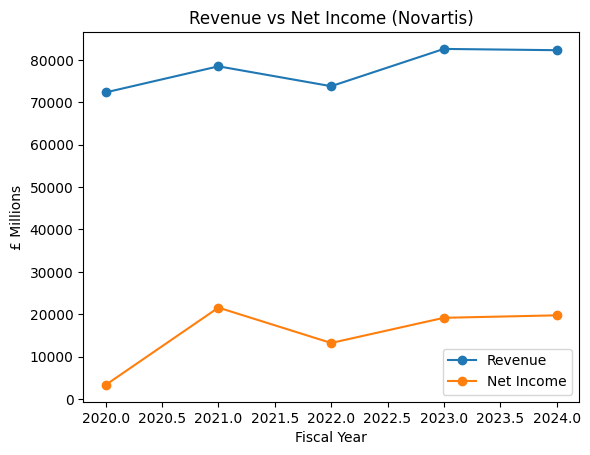

In [54]:
df_company = df[
    (df["company_name"].str.lower() == "wellsfargo") &
    (df["report_type"].str.lower() == "annual")
]
df_company = df_company.sort_values("fiscal_year")

plt.plot(df_company["fiscal_year"], df_company["revenue_millions"], marker="o", label="Revenue")
plt.plot(df_company["fiscal_year"], df_company["net_income_millions"], marker="o", label="Net Income")
plt.xlabel("Fiscal Year")
plt.ylabel("£ Millions")
plt.title("Revenue vs Net Income (Novartis)")
plt.legend()
plt.show()

# Output 3:
### Revenue and Income for multiple companies and comparisons

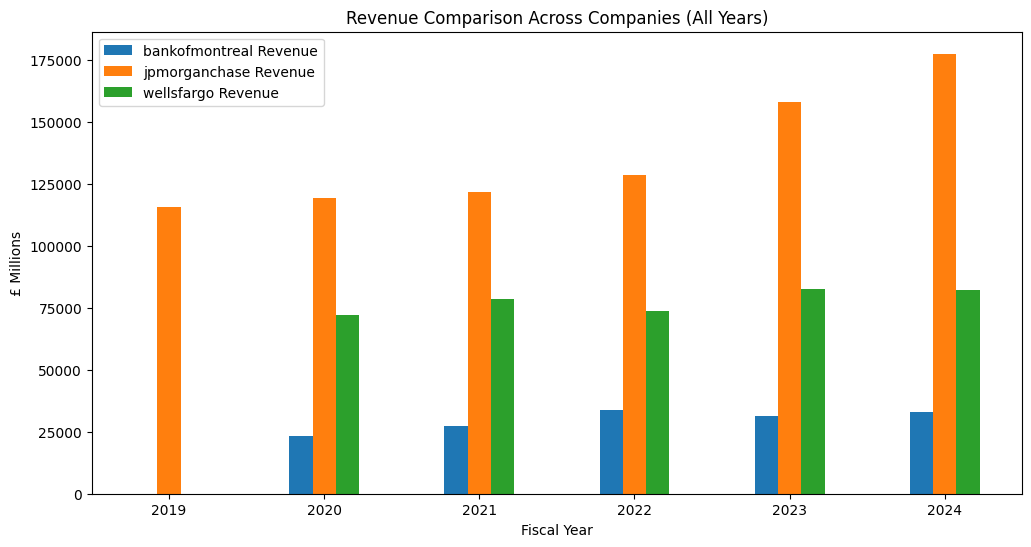

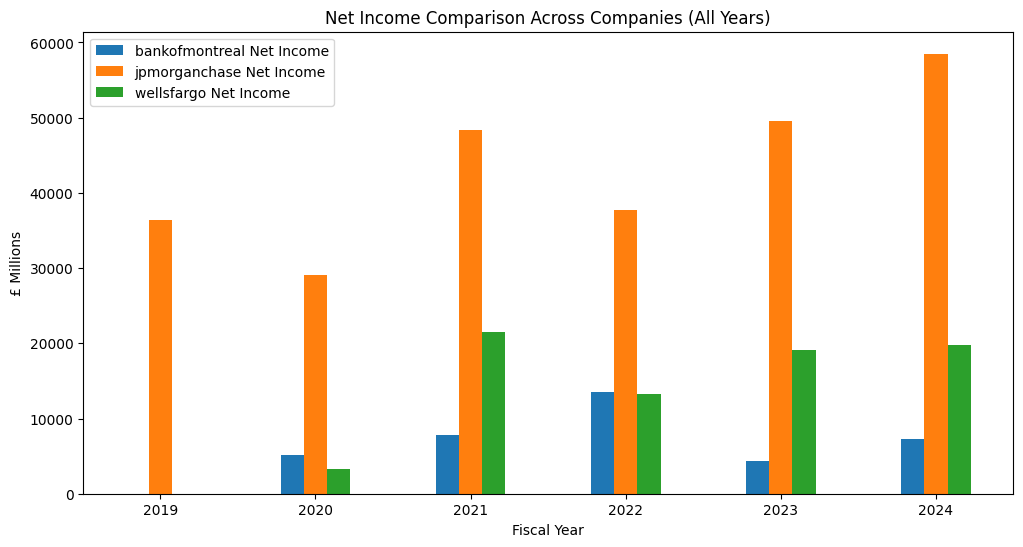

In [55]:

import numpy as np

# Filter only annual reports
df_filtered = df[df["report_type"].str.lower() == "annual"]

# Group by company and year
df_grouped = df_filtered.groupby(["company_name", "fiscal_year"])[
    ["revenue_millions", "net_income_millions"]
].sum().reset_index()

# Get unique values
companies = df_grouped["company_name"].unique().tolist()
years = sorted(df_grouped["fiscal_year"].unique())

# Set bar width
bar_width = 0.15
x = np.arange(len(years))  # positions for fiscal years

plt.figure(figsize=(12,6))

# Plot each company’s bars
for i, company in enumerate(companies):
    company_data = df_grouped[df_grouped["company_name"] == company]
    revenues = [company_data[company_data["fiscal_year"] == y]["revenue_millions"].sum() for y in years]
    plt.bar(x + i*bar_width, revenues, width=bar_width, label=f"{company} Revenue")

plt.xticks(x + bar_width*(len(companies)-1)/2, years)  # Center ticks
plt.xlabel("Fiscal Year")
plt.ylabel("£ Millions")
plt.title("Revenue Comparison Across Companies (All Years)")
plt.legend()
plt.show()

# Repeat for Net Income
plt.figure(figsize=(12,6))
for i, company in enumerate(companies):
    company_data = df_grouped[df_grouped["company_name"] == company]
    net_incomes = [company_data[company_data["fiscal_year"] == y]["net_income_millions"].sum() for y in years]
    plt.bar(x + i*bar_width, net_incomes, width=bar_width, label=f"{company} Net Income")

plt.xticks(x + bar_width*(len(companies)-1)/2, years)
plt.xlabel("Fiscal Year")
plt.ylabel("£ Millions")
plt.title("Net Income Comparison Across Companies (All Years)")
plt.legend()
plt.show()


# 🔮 Revenue Forecasting with AI.FORECAST & TimesFM 2.0


In [56]:
print("🔮 Generating revenue forecasts with TimesFM 2.0...")

forecast_sql = f"""
CREATE OR REPLACE TABLE `{QUALIFIED_FORECAST_TABLE_ID}` AS
SELECT
  *
FROM
  AI.FORECAST(
    TABLE `{QUALIFIED_METRICS_TABLE_ID}`,
    data_col => 'revenue_millions',
    timestamp_col => 'fiscal_year_date',
    model => 'TimesFM 2.0',
    id_cols => ['company_name'],
    horizon => 5,
    confidence_level => .95
  )
"""

print("⏳ Forecasting...")
job = client.query(forecast_sql)
job.result()
print("✅ Forecast table created successfully!")

🔮 Generating revenue forecasts with TimesFM 2.0...
⏳ Forecasting...
✅ Forecast table created successfully!


In [ ]:
# import requests
# from google.cloud import bigquery

# PROJECT_ID = "intellitrend-project-dev"   # update if needed
# DATASET_ID = "db_reports_insights_annual_esg"
# TABLE_ID = "all_reports_annual_esg"

# # Step 0: Fetch file list from GitHub
# url = "https://api.github.com/repos/intellitrend-global/google_hackathon_bq_ai/contents/annual_esg_reports"
# response = requests.get(url)
# files = response.json()

# pdf_files = [(f["name"], f["download_url"]) for f in files if f["name"].endswith(".pdf")]

# print("📄 Found PDF files on GitHub:")
# for name, link in pdf_files:
#     print(f"   {name} -> {link}")

# # Step 1: Initialize BigQuery client
# client = bigquery.Client(project=PROJECT_ID)

# # Step 2: Ensure dataset exists (create if not)
# dataset_ref = bigquery.DatasetReference(PROJECT_ID, DATASET_ID)
# try:
#     client.get_dataset(dataset_ref)  # Check if it exists
#     print(f"✅ Dataset {DATASET_ID} already exists")
# except Exception:
#     dataset = bigquery.Dataset(dataset_ref)
#     dataset.location = "US"
#     client.create_dataset(dataset, timeout=30)
#     print(f"📦 Created dataset {DATASET_ID}")

# # Step 3: Define schema
# schema = [
#     bigquery.SchemaField("filename", "STRING"),
#     bigquery.SchemaField("uri", "STRING"),
# ]

# # Step 4: Prepare rows
# rows = [{"filename": name, "uri": link} for name, link in pdf_files]

# # Step 5: Load into BigQuery
# job_config = bigquery.LoadJobConfig(schema=schema, write_disposition="WRITE_TRUNCATE")
# table_ref = f"{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}"

# job = client.load_table_from_json(rows, table_ref, job_config=job_config)
# job.result()

# print(f"✅ Table {table_ref} created/updated with {len(pdf_files)} GitHub files")
